<a href="https://colab.research.google.com/github/pinilDissanayaka/Bean-Leaf-Lesions-Classification/blob/main/Notebook_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
! kaggle datasets download marquis03/bean-leaf-lesions-classification

 94% 145M/155M [00:01<00:00, 137MB/s]
100% 155M/155M [00:01<00:00, 106MB/s]


In [3]:
! unzip /content/bean-leaf-lesions-classification.zip

Archive:  /content/bean-leaf-lesions-classification.zip
  inflating: classname.txt           
  inflating: train.csv               
  inflating: train/angular_leaf_spot/angular_leaf_spot_train.0.jpg  
  inflating: train/angular_leaf_spot/angular_leaf_spot_train.1.jpg  
  inflating: train/angular_leaf_spot/angular_leaf_spot_train.10.jpg  
  inflating: train/angular_leaf_spot/angular_leaf_spot_train.100.jpg  
  inflating: train/angular_leaf_spot/angular_leaf_spot_train.101.jpg  
  inflating: train/angular_leaf_spot/angular_leaf_spot_train.102.jpg  
  inflating: train/angular_leaf_spot/angular_leaf_spot_train.103.jpg  
  inflating: train/angular_leaf_spot/angular_leaf_spot_train.104.jpg  
  inflating: train/angular_leaf_spot/angular_leaf_spot_train.105.jpg  
  inflating: train/angular_leaf_spot/angular_leaf_spot_train.106.jpg  
  inflating: train/angular_leaf_spot/angular_leaf_spot_train.107.jpg  
  inflating: train/angular_leaf_spot/angular_leaf_spot_train.108.jpg  
  inflating: train/an

In [4]:
!pip install livelossplot
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 8.4 MB/s eta 0:00:00


In [30]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, AvgPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from livelossplot import PlotLossesKerasTF
import visualkeras
from glob import glob


import warnings
warnings.filterwarnings(action = 'ignore')

In [6]:
TRAIN_DIR = '/content/train.csv'
VALID_DIR = '/content/val.csv'

TRAIN_FOLDER = '/content/train'
VALID_FOLDER = '/content/val'

In [7]:
train_df = pd.read_csv(TRAIN_DIR)
valid_df = pd.read_csv(VALID_DIR)

In [8]:
train_df.head()

image:FILE  category
0   train/healthy/healthy_train.98.jpg         0
1  train/healthy/healthy_train.148.jpg         0
2  train/healthy/healthy_train.306.jpg         0
3  train/healthy/healthy_train.305.jpg         0
4   train/healthy/healthy_train.40.jpg         0

In [9]:
train_df.tail()

image:FILE  category
1029   train/bean_rust/bean_rust_train.29.jpg         2
1030  train/bean_rust/bean_rust_train.311.jpg         2
1031  train/bean_rust/bean_rust_train.336.jpg         2
1032  train/bean_rust/bean_rust_train.329.jpg         2
1033  train/bean_rust/bean_rust_train.186.jpg         2

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1034 entries, 0 to 1033
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image:FILE  1034 non-null   object
 1   category    1034 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 16.3+ KB


In [11]:
train_df.duplicated().sum()

0

In [12]:
train_df.isnull().sum()

image:FILE    0
category      0
dtype: int64

In [13]:
valid_df.head()

image:FILE  category
0  val/healthy/healthy_val.25.jpg         0
1  val/healthy/healthy_val.32.jpg         0
2   val/healthy/healthy_val.3.jpg         0
3  val/healthy/healthy_val.16.jpg         0
4  val/healthy/healthy_val.10.jpg         0

In [14]:
valid_df.tail()

image:FILE  category
128  val/bean_rust/bean_rust_val.43.jpg         2
129  val/bean_rust/bean_rust_val.17.jpg         2
130  val/bean_rust/bean_rust_val.38.jpg         2
131  val/bean_rust/bean_rust_val.16.jpg         2
132  val/bean_rust/bean_rust_val.40.jpg         2

In [15]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image:FILE  133 non-null    object
 1   category    133 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


In [16]:
valid_df.duplicated().sum()

0

In [17]:
valid_df.isnull().sum()

image:FILE    0
category      0
dtype: int64

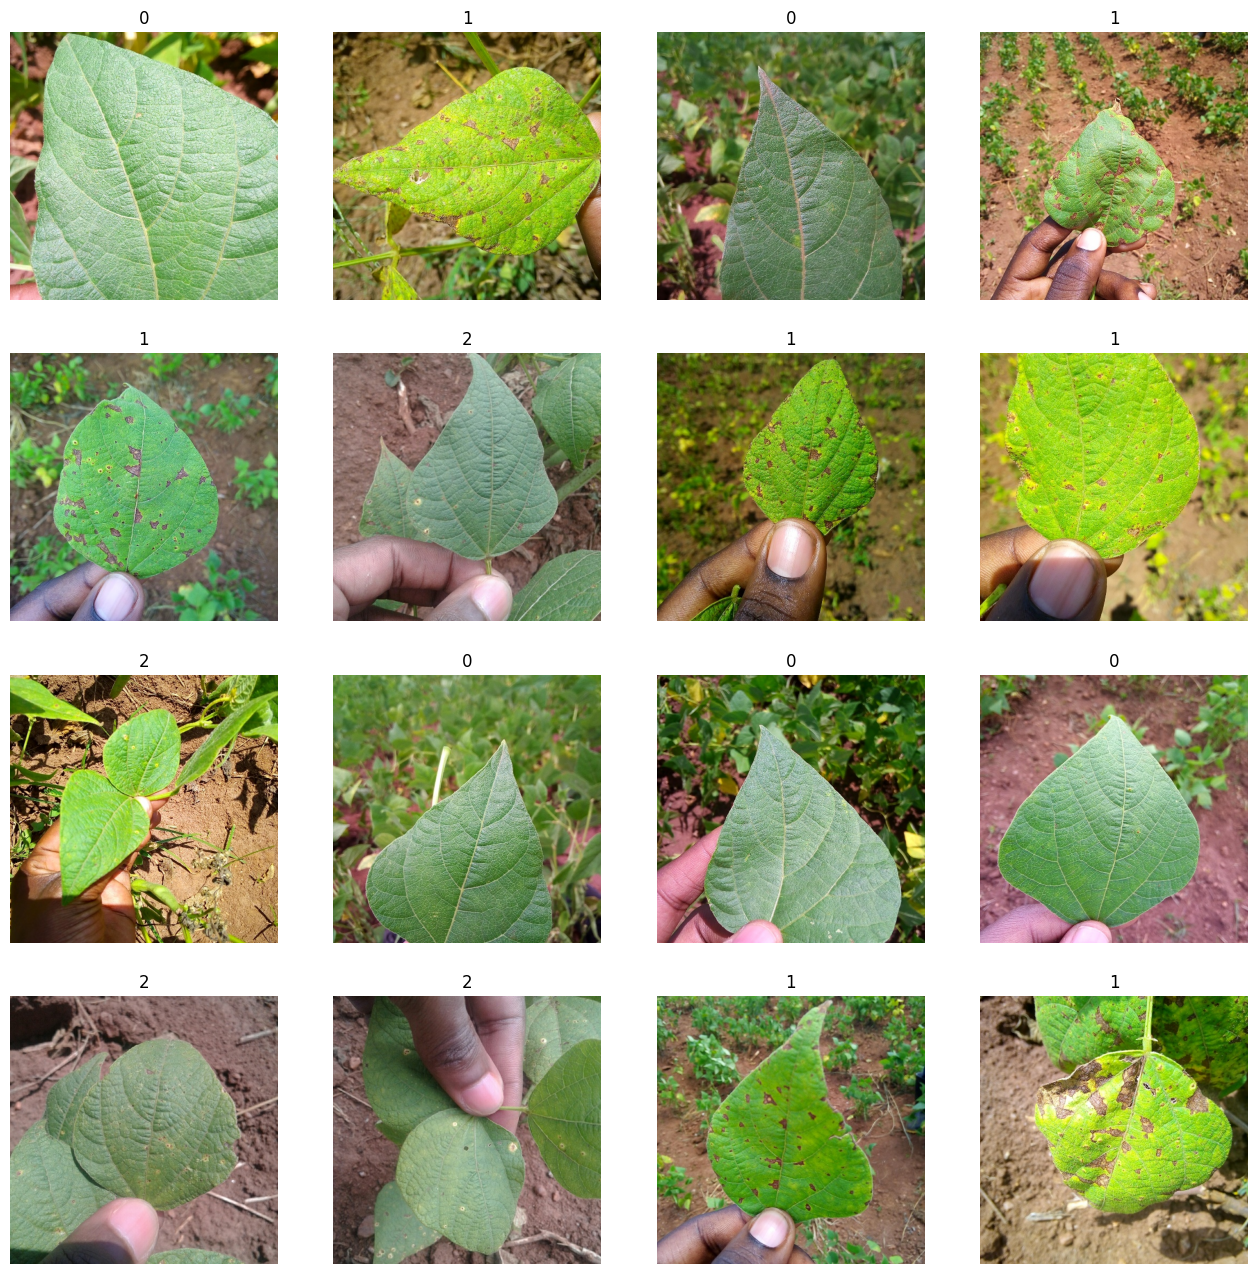

In [18]:
train_sample = train_df.sample(16, random_state=4)

fig = plt.figure(figsize = (16, 16))
for i in range(len(train_sample.index)):
  fig.add_subplot(4, 4, i+1)
  img = plt.imread(train_sample['image:FILE'].values[i])
  plt.imshow(img)
  plt.axis('off')
  plt.title(train_sample['category'].values[i])

plt.show()

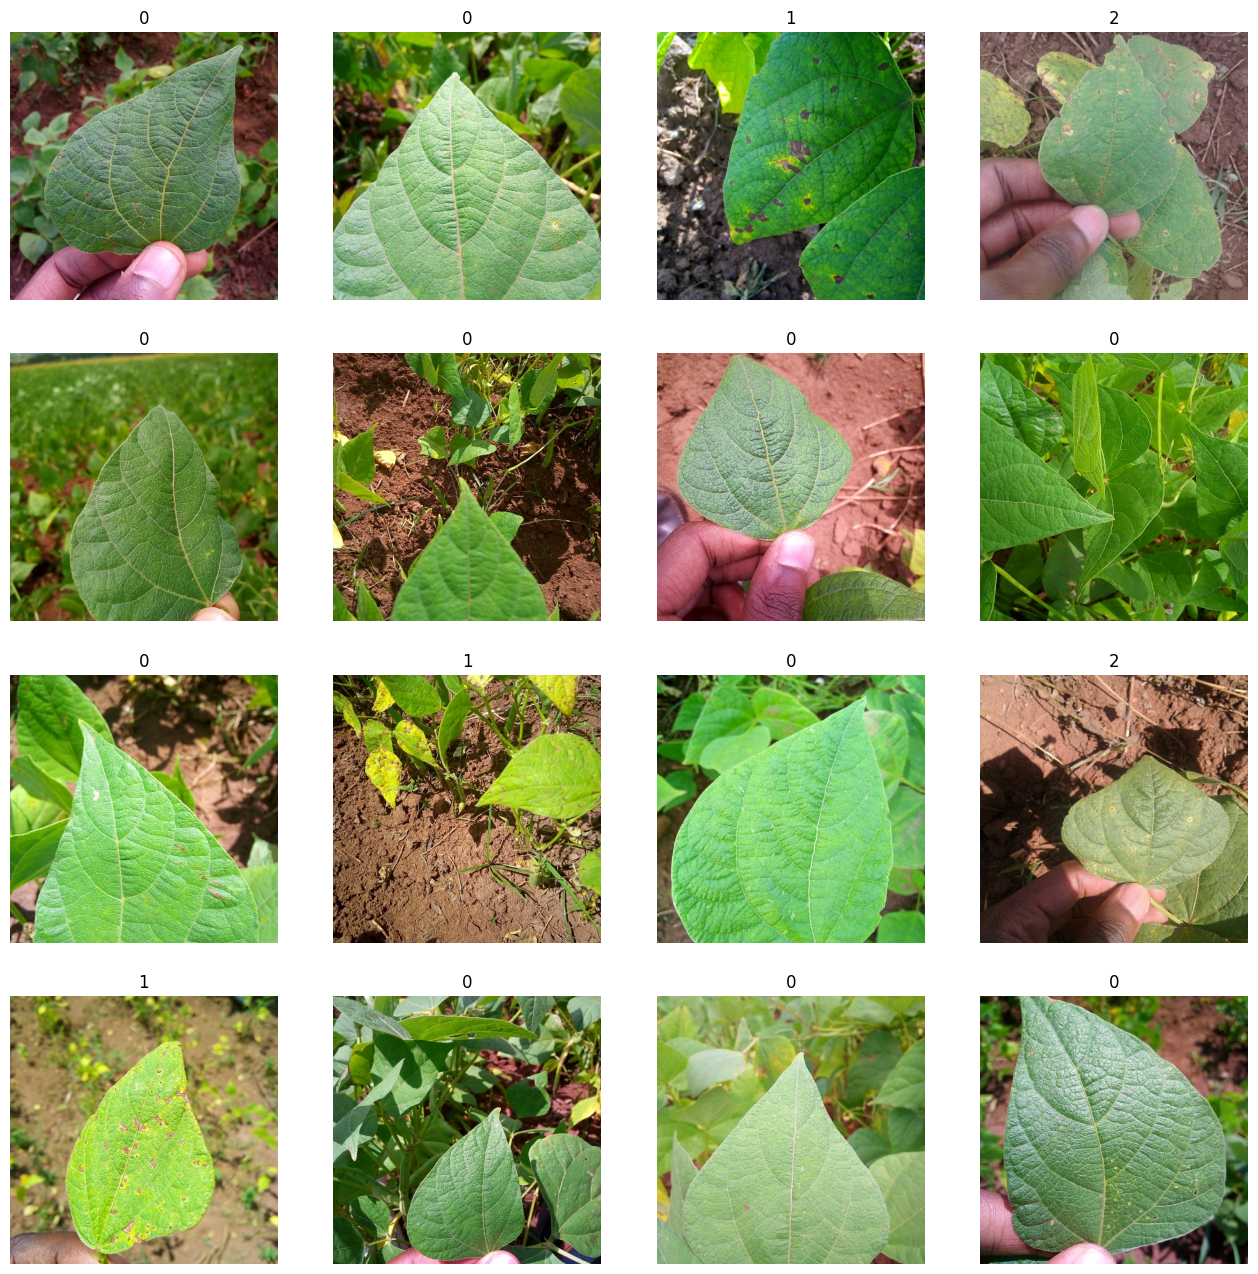

In [19]:
valid_sample = valid_df.sample(16, random_state=4)

fig = plt.figure(figsize = (16, 16))
for i in range(len(valid_sample.index)):
  fig.add_subplot(4, 4, i+1)
  img = plt.imread(valid_sample['image:FILE'].values[i])
  plt.imshow(img)
  plt.axis('off')
  plt.title(valid_sample['category'].values[i])

plt.show()

In [20]:
trainImgShape = set()
validImgShape = set()

for i in train_df['image:FILE'].values:
  img = plt.imread(i)
  size = img.shape
  trainImgShape.add(size)

for i in valid_df['image:FILE'].values:
  img = plt.imread(i)
  size = img.shape
  validImgShape.add(size)

In [21]:
print(f"Training images has {trainImgShape} shape")
print(f"Validation images has {validImgShape} shape")

Training images has {(500, 500, 3)} shape
Validation images has {(500, 500, 3)} shape


In [78]:
INPUT_SIZE = [224, 224, 1]

2    348
1    345
0    341
Name: category, dtype: int64


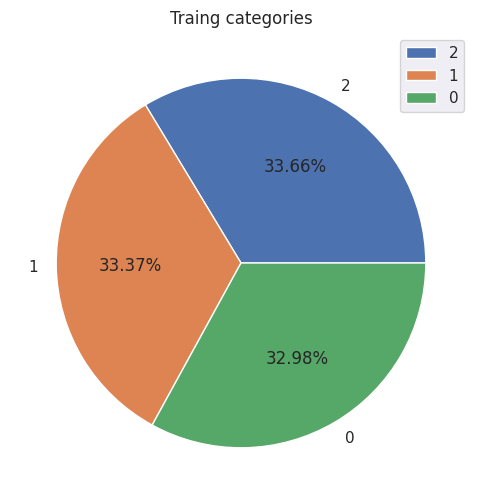

In [23]:
i = train_df['category'].value_counts()
print(i)

sns.set()
plt.figure(figsize = (6, 6))
plt.title("Traing categories")
plt.pie(x = i.values, labels = i.index, autopct= '%1.2f%%')
plt.legend()
plt.show()

2    45
0    44
1    44
Name: category, dtype: int64


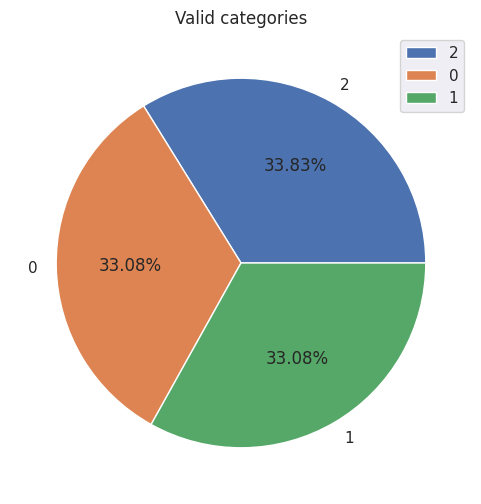

In [24]:
i = valid_df['category'].value_counts()
print(i)

sns.set()
plt.figure(figsize = (6, 6))
plt.title("Valid categories")
plt.pie(x = i.values, labels = i.index, autopct= '%1.2f%%')
plt.legend()
plt.show()

In [25]:
trainDataGen = ImageDataGenerator(rescale = 1./255,
                               shear_range = 0.6,
                               zoom_range = 0.3,
                               horizontal_flip = True)

validDataGen = ImageDataGenerator(rescale = 1./255)

In [82]:
df_train = trainDataGen.flow_from_directory(directory=TRAIN_FOLDER,
                                            target_size = (224, 224),
                                            color_mode = 'grayscale',
                                            class_mode='categorical',
                                            batch_size = 16)

df_valid = validDataGen.flow_from_directory(directory=VALID_FOLDER,
                                            target_size = (224, 224),
                                            color_mode = 'grayscale',
                                            class_mode='categorical',
                                            batch_size = 16)

Found 1034 images belonging to 3 classes.
Found 133 images belonging to 3 classes.


In [83]:
trainingSteps = df_train.n // df_train.batch_size
validingSteps = df_valid.n // df_valid.batch_size

print(f"Training epoch has {trainingSteps} steps")
print(f"Validating epoch has {validingSteps} steps")

Training epoch has 64 steps
Validating epoch has 8 steps


In [84]:
outDist = df_train.class_indices

OUT_SIZE = len(list(outDist.values()))

outDist

{'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2}

In [98]:
model = Sequential()

model.add(Conv2D(128, (3, 3), padding='same', input_shape=INPUT_SIZE, activation= 'relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation= 'relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation= 'relu'))
model.add(BatchNormalization())
model.add(AvgPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', activation= 'relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation= 'relu'))
model.add(AvgPool2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3), padding='same', activation= 'relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation= 'relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation= 'relu'))
model.add(AvgPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3), padding='same', activation= 'relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation= 'relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(AvgPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(BatchNormalization())
model.add(AvgPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(BatchNormalization())
model.add(AvgPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(AvgPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(64, activation= 'relu'))
model.add(Dropout(0.2))
model.add(Dense(OUT_SIZE, activation='softmax'))


model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_264 (Conv2D)         (None, 224, 224, 128)     1280      
                                                                 
 conv2d_265 (Conv2D)         (None, 224, 224, 128)     147584    
                                                                 
 conv2d_266 (Conv2D)         (None, 224, 224, 128)     147584    
                                                                 
 batch_normalization_27 (Ba  (None, 224, 224, 128)     512       
 tchNormalization)                                               
                                                                 
 average_pooling2d_74 (Aver  (None, 112, 112, 128)     0         
 agePooling2D)                                                   
                                                                 
 conv2d_267 (Conv2D)         (None, 112, 112, 256)   

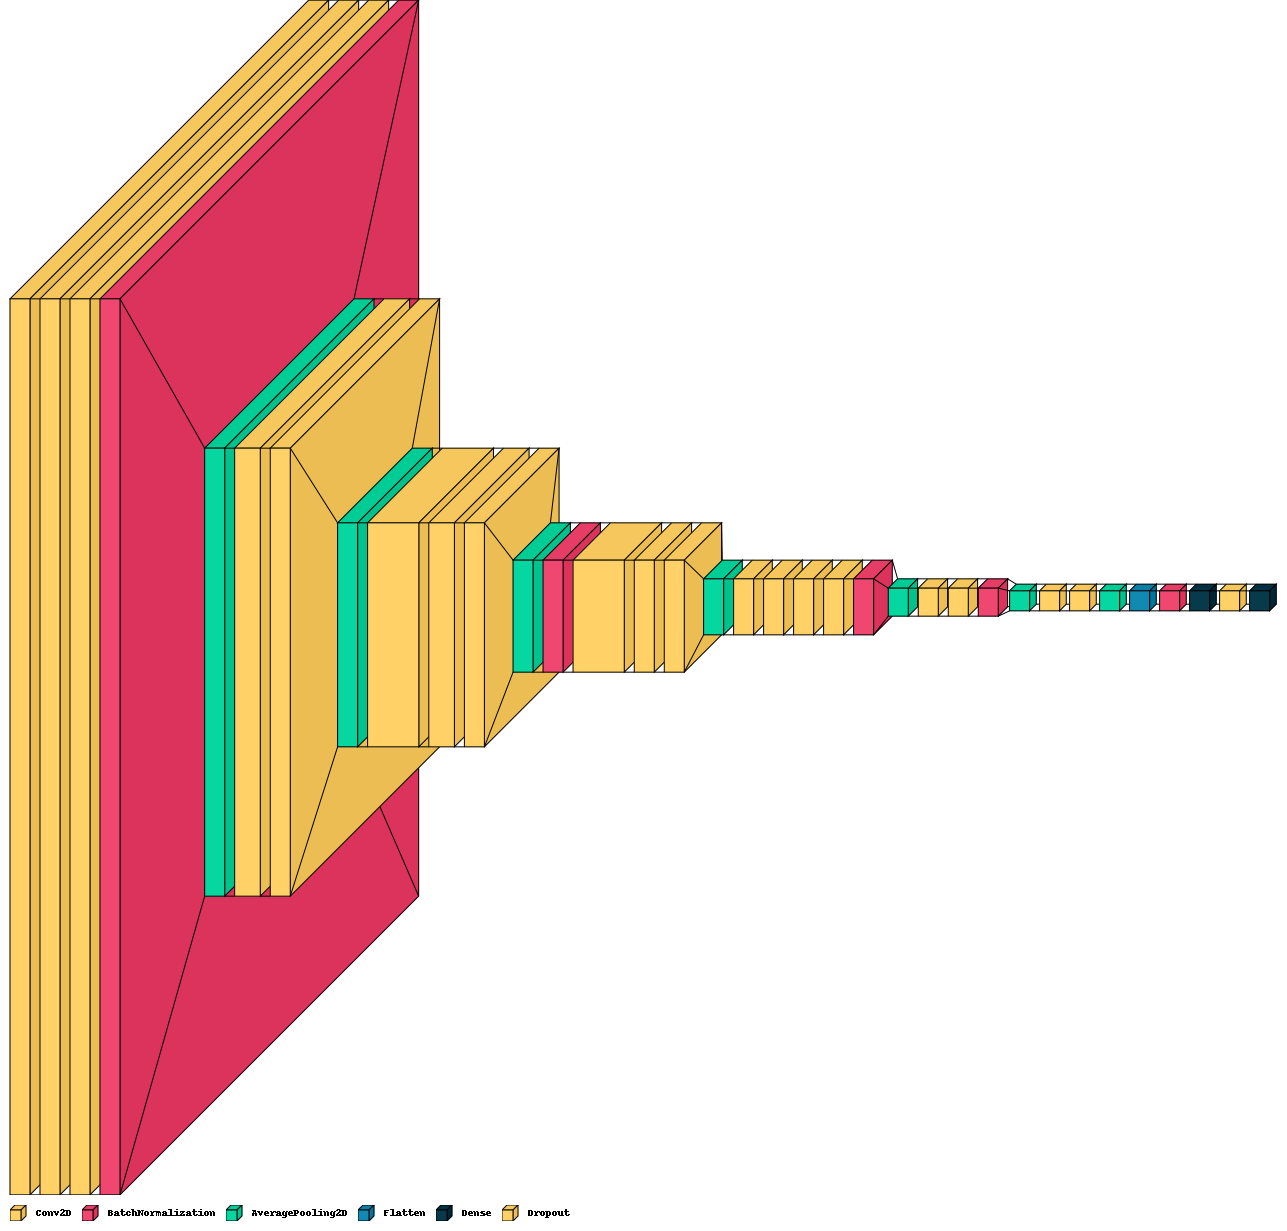

In [99]:
visualkeras.layered_view(model, legend =True)

In [100]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [101]:
earlyStopping = EarlyStopping(monitor='val_loss',
                              patience=2,
                              verbose=1)

reduceLr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=2,
                              min_lr=0.000001,
                              model='auto')

modelCheck = ModelCheckpoint("model_weights.h5",
                             monitor="val_accuracy",
                             save_weights_only=True,
                             mode="max",
                             verbose=1)


callBacks = [earlyStopping, reduceLr, modelCheck, PlotLossesKerasTF()]

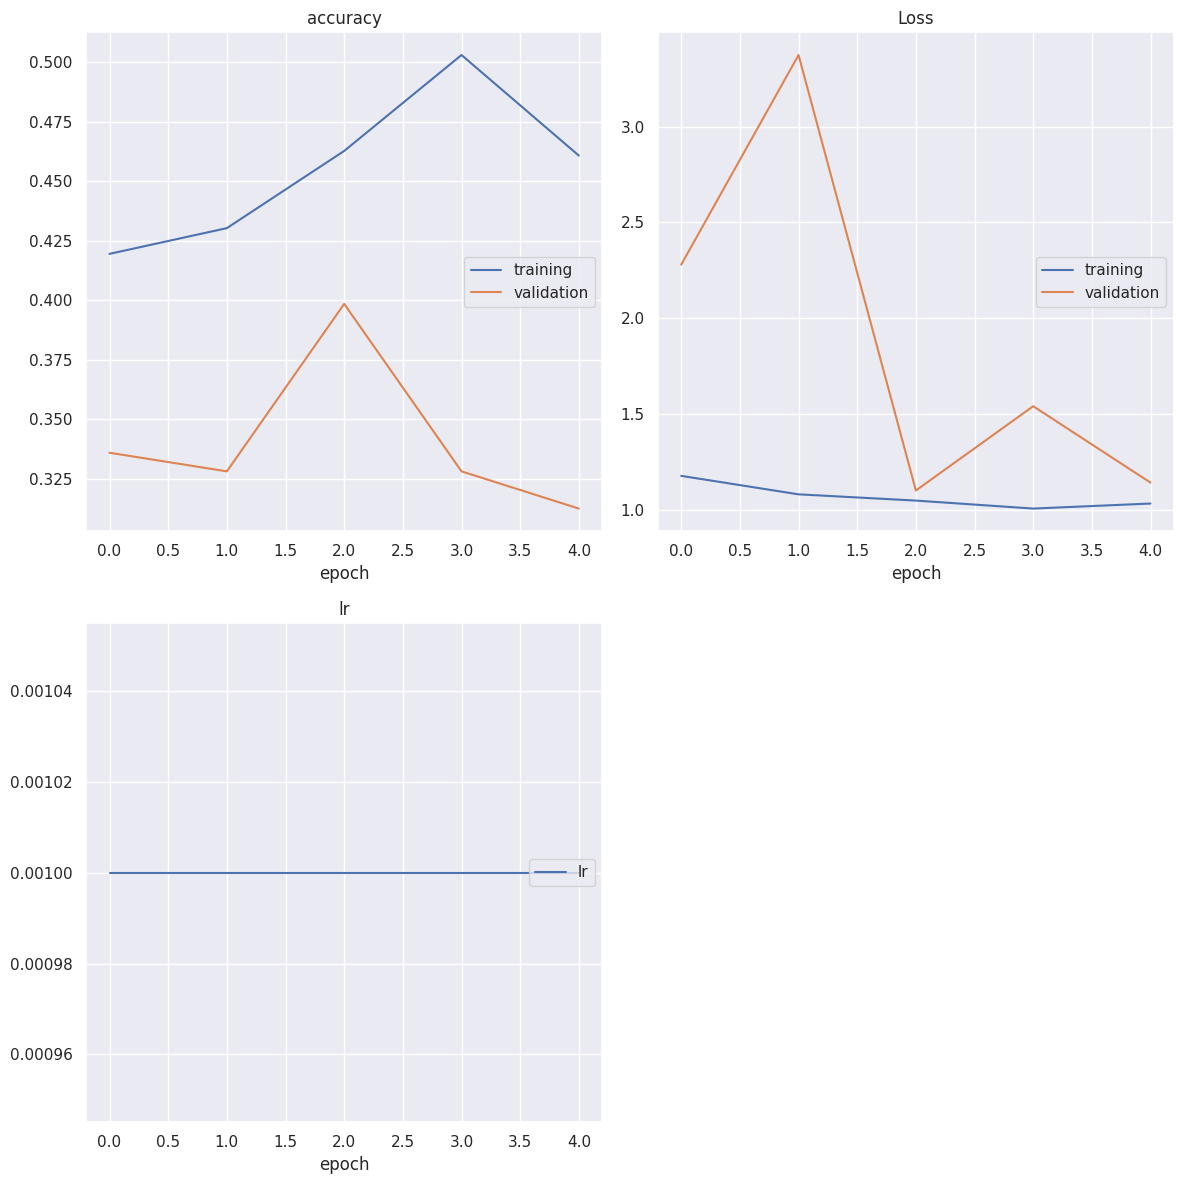

accuracy
	training         	 (min:    0.419, max:    0.503, cur:    0.461)
	validation       	 (min:    0.312, max:    0.398, cur:    0.312)
Loss
	training         	 (min:    1.007, max:    1.177, cur:    1.033)
	validation       	 (min:    1.101, max:    3.374, cur:    1.142)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
64/64 [==============================] - 30s 473ms/step - loss: 1.0331 - accuracy: 0.4607 - val_loss: 1.1422 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 5: early stopping


In [102]:
modelHist = model.fit_generator(df_train,
                    steps_per_epoch= trainingSteps,
                    epochs = 12,
                    verbose = 1,
                    callbacks=callBacks,
                    validation_data=df_valid,
                    validation_steps= validingSteps)